In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd

import dask
import dask.array as da
from dask import delayed

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patheffects as PathEffects
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

from scipy.ndimage.measurements import center_of_mass

from glob import glob

from datetime import datetime, timedelta

import scipy.stats as stats
import zarr

ERROR 1: PROJ: proj_create_from_database: Open of /home/bwallace/anaconda3/envs/analysis/share/proj failed
/var/tmp/pbs.1882978.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_783993/1401984697.py:22: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection;
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-96.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

In [3]:
coarsen_size=20 #make sure this is consistent with the coarsen_size specified in calculate_mcs_anomaly

wrf_native_coords=xr.open_dataset('/eagle/climate_severe/geog/geo_em.d01.nc')
wrf_lat=wrf_native_coords.XLAT_M[0]
wrf_lon=wrf_native_coords.XLONG_M[0]

wrf_lat_coarse=wrf_lat.coarsen(south_north=coarsen_size,boundary='trim').mean()\
.coarsen(west_east=coarsen_size,boundary='trim').mean()
wrf_lon_coarse=wrf_lon.coarsen(south_north=coarsen_size,boundary='trim').mean()\
.coarsen(west_east=coarsen_size,boundary='trim').mean()

# request data for use by geopandas
resolution = '110m'
category = 'cultural'
name = 'admin_0_countries'


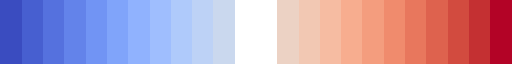

In [4]:
new_colors=plt.get_cmap('coolwarm')(np.linspace(0,1,256))
new_colors[120:140]=[1,1,1,1]

seis_cmap=mcolors.ListedColormap(new_colors).resampled(24)
seis_cmap

In [5]:
mean_mfc_hist = xr.open_dataset('/eagle/climate_severe/bwallace_scratch/paper_repo/mfc_hist.nc')['mfc']
mean_mfc_eoc8 = xr.open_dataset('/eagle/climate_severe/bwallace_scratch/paper_repo/mfc_eoc85.nc')['mfc']

mfc_thermo = xr.open_dataset('/eagle/climate_severe/bwallace_scratch/paper_repo/mfc_thermo.nc')['mfc']
mfc_dyno = xr.open_dataset('/eagle/climate_severe/bwallace_scratch/paper_repo/mfc_dyno.nc')['mfc']
mfc_transient = xr.open_dataset('/eagle/climate_severe/bwallace_scratch/paper_repo/mfc_transient.nc')['mfc']

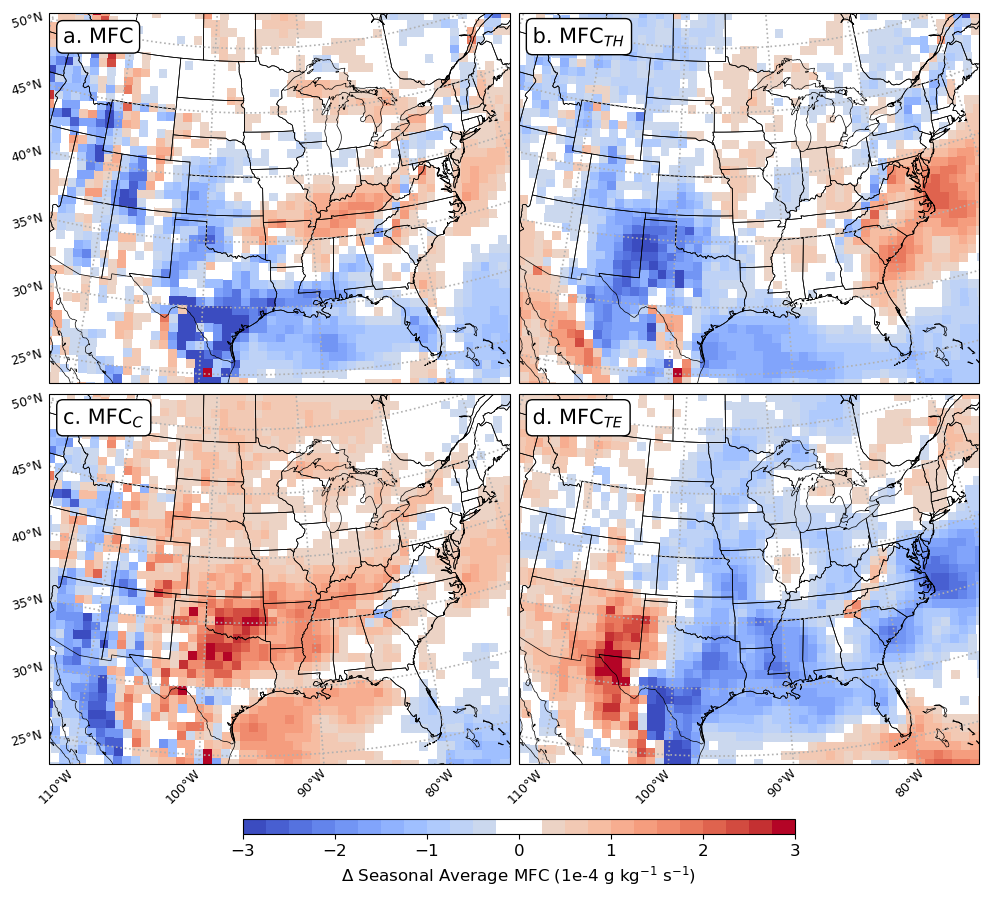

In [6]:
xrng,yrng=3,3
letters=['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.', 'l.', 'm.', 'n.', 'p.',]
label_order = ['MFC', 'MFC$_{TH}$', 'MFC$_{C}$', 'MFC$_{TE}$']

fig = plt.figure(figsize = (12,10))
gs=fig.add_gridspec(2,2)

for i in range(4):
    ax=fig.add_subplot(gs[i//2,i%2],projection=plotproj)
    ax.set_extent([-112., -75, 24, 51],ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
    ax.add_feature(cfeature.STATES,linewidth=0.5)

    if i==0:
        c=ax.pcolormesh(
            wrf_lon_coarse,
            wrf_lat_coarse,
            (mean_mfc_eoc8 - mean_mfc_hist) * 1e4,
            vmin=-3, vmax=3,
            cmap=seis_cmap,
            transform=dataproj)
    elif i==1:
        c=ax.pcolormesh(
            wrf_lon_coarse,
            wrf_lat_coarse,
            mfc_thermo * 1e4,
            vmin=-3, vmax=3,
            cmap=seis_cmap,
            transform=dataproj)
    elif i==2:
        c=ax.pcolormesh(
            wrf_lon_coarse,
            wrf_lat_coarse,
            mfc_dyno * 1e4,
            vmin=-3, vmax=3,
            cmap=seis_cmap,
            transform=dataproj)
    elif i==3:
        c=ax.pcolormesh(
            wrf_lon_coarse,
            wrf_lat_coarse,
            mfc_transient * 1e4,
            vmin=-3, vmax=3,
            cmap=seis_cmap,
            transform=dataproj)

    ll=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linestyle=':',lw=1.2)
    ll.top_labels=False
    ll.right_labels=False
    if i%2 != 0:
        ll.left_labels = False
    if i//2 == 0:
        ll.bottom_labels=False
    ll.xlocator = mticker.FixedLocator([-120,-110,-100,-90,-80,-70])
    ll.rotate_labels=True
    ll.xlabel_style = {'rotation':45,  'size':9}
    ll.ylabel_style = {'rotation':15, 'size':9}

    t=ax.text(0.03,0.92,letters[i]+' '+label_order[i],
              horizontalalignment='left',
              size=15,color='k',
              path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
              transform=ax.transAxes)
    t.set_bbox(dict(boxstyle='round',facecolor='white',alpha=1,edgecolor='black'))

    if i == 3:
        axins = inset_axes(
            ax,
            width="300%",  # width: 5% of parent_bbox width
            height="5%",  # height: 50%
            bbox_to_anchor=(0.2, -0.95, 0.4, 0.8),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )

        cbar=plt.colorbar(c,cax=axins,orientation='horizontal',aspect=25,fraction=0.01,pad=0.5,
                         ticks=[-3, -2, -1, 0, 1, 2, 3])
        cbar.set_label('$\Delta$ Seasonal Average MFC (1e-4 g kg$^{-1}$ s$^{-1}$)',fontsize=12)
        cbar.ax.tick_params(labelsize=12)


plt.subplots_adjust(wspace=0.02, hspace=-0.02)
plt.show()
plt.close()